In [1]:
import pandas as pd

#Leitura do arquivo
df_sem_alta = pd.read_pickle('../../dados_sem_alta_favoravel_desfavoravel.pickle')

# Ver as primeiras linhas do DataFrame
df_sem_alta.head()

# Ver as colunas disponíveis
df_sem_alta.columns

# Ver informações gerais (tipos, quantidade de dados, nulos, etc.)
df_sem_alta.info()

# Ver estatísticas descritivas das colunas numéricas
df_sem_alta.describe()



<class 'pandas.core.frame.DataFrame'>
Index: 53104 entries, 918696 to 408788
Data columns (total 59 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   AP_PRIPAL                          53104 non-null  object 
 1   AP_UFMUN                           53104 non-null  object 
 2   AP_CNSPCN                          53104 non-null  object 
 3   AP_NUIDADE                         53104 non-null  int64  
 4   AP_SEXO                            53104 non-null  object 
 5   AP_RACACOR                         53104 non-null  int64  
 6   AP_MUNPCN                          53104 non-null  object 
 7   AP_UFNACIO                         53104 non-null  object 
 8   AP_DTINIC                          53104 non-null  float64
 9   AP_DTFIM                           53104 non-null  float64
 10  AP_MOTSAI                          53104 non-null  int64  
 11  AP_TRANSF                          53104 non-null  in

,AP_NUIDADE,AP_RACACOR,AP_DTINIC,AP_DTFIM,AP_MOTSAI,AP_TRANSF,AQ_ESTADI,NUMERO_DE_TRATAMENTOS_ANTERIORES,NUMERO_DE_DIAGNOSTICOS_DIFERENTES,TEM_CAUSAS_ASSOCIADAS,...,FULVESTRANTO,VINORELBINA,GENCITABINA,GOSSERELINA,PAMIDRONATO,PERTUZUMABE,CISPLATINA,LEUPRORRELINA,Total_Medicamentos,VALOR_DESFECHO
count,53104.000000,53104.000000,5.310400e+04,5.310400e+04,53104.000000,53104.000000,53104.000000,53104.000000,53104.000000,53104.0,...,53104.0,53104.000000,53104.000000,53104.0,53104.0,53104.000000,53104.000000,53104.0,53104.000000,53104.000000
mean,52.017532,15.561577,1.517734e+09,1.524664e+09,22.023049,0.000113,2.695541,0.084702,1.000734,1.0,...,0.0,0.000471,0.003898,0.0,0.0,0.000301,0.003258,0.0,1.426936,0.338600
std,11.974690,33.891133,1.363339e+08,1.364209e+08,5.081984,0.010629,0.778376,0.344739,0.031584,0.0,...,0.0,0.021692,0.062313,0.0,0.0,0.017355,0.056984,0.0,0.705360,0.473238
min,1.000000,1.000000,1.199146e+09,1.201738e+09,11.000000,0.000000,0.000000,0.000000,1.000000,1.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
25%,43.000000,1.000000,1.435709e+09,1.440979e+09,21.000000,0.000000,3.000000,0.000000,1.000000,1.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000
50%,52.000000,2.000000,1.553861e+09,1.559261e+09,21.000000,0.000000,3.000000,0.000000,1.000000,1.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000
75%,60.000000,3.000000,1.626739e+09,1.632960e+09,21.000000,0.000000,3.000000,0.000000,1.000000,1.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,2.000000,1.000000
max,96.000000,99.000000,1.735603e+09,1.740701e+09,51.000000,1.000000,4.000000,3.000000,4.000000,1.0,...,0.0,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0,6.000000,1.000000


In [2]:
df_sem_alta.columns

Index(['AP_PRIPAL', 'AP_UFMUN', 'AP_CNSPCN', 'AP_NUIDADE', 'AP_SEXO',
       'AP_RACACOR', 'AP_MUNPCN', 'AP_UFNACIO', 'AP_DTINIC', 'AP_DTFIM',
       'AP_MOTSAI', 'AP_TRANSF', 'AP_CIDCAS', 'AP_CIDSEC', 'AQ_LINFIN',
       'AQ_ESTADI', 'AQ_GRAHIS', 'AQ_TRANTE', 'AQ_CONTTR', 'AP_APACANT',
       'ESQUEMA_TERAPEUTICO', 'NUMERO_DE_TRATAMENTOS_ANTERIORES',
       'NUMERO_DE_DIAGNOSTICOS_DIFERENTES', 'TEM_CAUSAS_ASSOCIADAS',
       'TEM_CAUSAS_SECUNDARIA', 'INICIO', 'ESTADIAMENTO_INICIO', 'FIM',
       'ESTADIAMENTO_FIM', 'DIF_ESTADIAMENTO', 'TOTAL_TRATAMENTOS',
       'PROCEDIMENTO_INICIAL', 'DESFECHO', 'CODIGO_6D', 'PACLITAXEL',
       'DOXORRUBICINA', 'CICLOFOSFAMIDA', 'FLUOROURACILA', 'METOTREXATO',
       'EPIRRUBICINA', 'DOCETAXEL', 'TRASTUZUMABE', 'TAMOXIFENO',
       'CAPECITABINA', 'LETROZOL', 'ANASTROZOL', 'CARBOPLATINA', 'EXEMESTANO',
       'FULVESTRANTO', 'VINORELBINA', 'GENCITABINA', 'GOSSERELINA',
       'PAMIDRONATO', 'PERTUZUMABE', 'CISPLATINA', 'LEUPRORRELINA',
       'ABRE

In [3]:
df_sem_alta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53104 entries, 918696 to 408788
Data columns (total 59 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   AP_PRIPAL                          53104 non-null  object 
 1   AP_UFMUN                           53104 non-null  object 
 2   AP_CNSPCN                          53104 non-null  object 
 3   AP_NUIDADE                         53104 non-null  int64  
 4   AP_SEXO                            53104 non-null  object 
 5   AP_RACACOR                         53104 non-null  int64  
 6   AP_MUNPCN                          53104 non-null  object 
 7   AP_UFNACIO                         53104 non-null  object 
 8   AP_DTINIC                          53104 non-null  float64
 9   AP_DTFIM                           53104 non-null  float64
 10  AP_MOTSAI                          53104 non-null  int64  
 11  AP_TRANSF                          53104 non-null  in

In [4]:
df_sem_alta.head()

,AP_PRIPAL,AP_UFMUN,AP_CNSPCN,AP_NUIDADE,AP_SEXO,AP_RACACOR,AP_MUNPCN,AP_UFNACIO,AP_DTINIC,AP_DTFIM,...,VINORELBINA,GENCITABINA,GOSSERELINA,PAMIDRONATO,PERTUZUMABE,CISPLATINA,LEUPRORRELINA,ABREVIATURA_PROTOCOLO,Total_Medicamentos,VALOR_DESFECHO
918696,0304040029,SP,|{{~~ü|}|ä~{{{â,72,F,1,SP,Brasil,1.243555e+09,1.248998e+09,...,0,0,0,0,0,0,0,DOX,1,0
1073812,0304040029,SP,|{{~~ü|}|ä~{{{â,72,F,1,SP,Brasil,1.257811e+09,1.264896e+09,...,0,0,0,0,0,0,0,PTX,1,0
397157,0304040029,ES,|{{~é{ââ|ü{{{Ç,70,F,3,ES,Brasil,1.623715e+09,1.630368e+09,...,0,0,0,0,0,0,0,CFX,1,0
408520,0304040185,ES,|{{~é{ââ|ü{{{Ç,71,F,3,ES,Brasil,1.631059e+09,1.638230e+09,...,0,0,0,0,0,0,0,DTX,1,0
13567415,0304040029,RJ,|{{|éâÇ{{{Ç,60,F,2,RJ,Brasil,1.277942e+09,1.285805e+09,...,0,0,0,0,0,0,0,DOX+CFX+5FU,3,0


In [5]:
from sklearn.preprocessing import LabelEncoder

# Cria o codificador
le_uf = LabelEncoder()

# Aplica o encoder na coluna AP_UFMUN
df_sem_alta['AP_UFMUN_NUM'] = le_uf.fit_transform(df_sem_alta['AP_UFMUN'])

# Visualiza o mapeamento original -> número
uf_mapping = dict(zip(le_uf.classes_, le_uf.transform(le_uf.classes_)))
print("Mapeamento UF -> Número:")
print(uf_mapping)


Mapeamento UF -> Número:
{'ES': 0, 'MG': 1, 'RJ': 2, 'SP': 3}


In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif

# Listas de variáveis numéricas e de medicamentos usadas na análise
numerical_cols = [
    'AP_PRIPAL', 'AP_DTINIC', 'AP_DTFIM', 'AP_NUIDADE', 'AP_RACACOR',
    'AP_MOTSAI', 'AP_TRANSF', 'NUMERO_DE_TRATAMENTOS_ANTERIORES',
    'NUMERO_DE_DIAGNOSTICOS_DIFERENTES', 'TEM_CAUSAS_ASSOCIADAS',
    'TEM_CAUSAS_SECUNDARIA', 'ESTADIAMENTO_INICIO', 'ESTADIAMENTO_FIM',
    'DIF_ESTADIAMENTO', 'TOTAL_TRATAMENTOS', 'PROCEDIMENTO_INICIAL',
    'Total_Medicamentos', 'AP_UFMUN_NUM'
]

medicamentos = [
    'PACLITAXEL', 'DOXORRUBICINA', 'CICLOFOSFAMIDA', 'FLUOROURACILA',
    'METOTREXATO', 'EPIRRUBICINA', 'DOCETAXEL', 'TRASTUZUMABE', 'TAMOXIFENO',
    'CAPECITABINA', 'LETROZOL', 'ANASTROZOL', 'CARBOPLATINA', 'EXEMESTANO',
    'FULVESTRANTO', 'VINORELBINA', 'GENCITABINA', 'GOSSERELINA', 'PAMIDRONATO',
    'PERTUZUMABE', 'CISPLATINA', 'LEUPRORRELINA'
]

# Seleção das variáveis explicativas e do alvo
X = df_sem_alta[numerical_cols + medicamentos]
y = df_sem_alta['VALOR_DESFECHO']

# Cálculo da informação mútua
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

# Ordenação dos resultados por relevância
mi_series = pd.Series(mi_scores, index=X.columns)
top_15 = mi_series.sort_values(ascending=False)

# Exibição das variáveis mais relevantes
print(top_15)



DIF_ESTADIAMENTO                     0.496017
ESTADIAMENTO_FIM                     0.143653
ESTADIAMENTO_INICIO                  0.094103
AP_DTINIC                            0.086598
AP_DTFIM                             0.078154
PROCEDIMENTO_INICIAL                 0.051106
AP_UFMUN_NUM                         0.040082
AP_MOTSAI                            0.020641
TOTAL_TRATAMENTOS                    0.012705
AP_PRIPAL                            0.008635
TEM_CAUSAS_SECUNDARIA                0.007820
DOXORRUBICINA                        0.006682
Total_Medicamentos                   0.006125
TEM_CAUSAS_ASSOCIADAS                0.005383
NUMERO_DE_DIAGNOSTICOS_DIFERENTES    0.002936
DOCETAXEL                            0.002652
EPIRRUBICINA                         0.002466
ANASTROZOL                           0.002226
EXEMESTANO                           0.001850
AP_NUIDADE                           0.001528
FLUOROURACILA                        0.001265
CAPECITABINA                      

[codecarbon WARNING @ 22:08:50] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:08:50] [setup] RAM Tracking...
[codecarbon INFO @ 22:08:50] [setup] CPU Tracking...
[codecarbon WARNING @ 22:08:53] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 22:08:53] CPU Model on constant consumption mode: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz
[codecarbon WARNING @ 22:08:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:08:53] [setup] GPU Tracking...
[codecarbon INFO @ 22:08:53] No GPU found.
[codecarbon INFO @ 22:08:53] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:08:53] >>> Tracker's metadat

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[codecarbon INFO @ 22:09:11] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:09:11] Delta energy consumed for CPU with constant : 0.000468 kWh, power : 112.0 W
[codecarbon INFO @ 22:09:11] Energy consumed for All CPU : 0.000468 kWh
[codecarbon INFO @ 22:09:11] 0.000510 kWh of electricity used since the beginning.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[codecarbon INFO @ 22:09:26] Energy consumed for RAM : 0.000084 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:09:26] Delta energy consumed for CPU with constant : 0.000472 kWh, power : 112.0 W
[codecarbon INFO @ 22:09:26] Energy consumed for All CPU : 0.000940 kWh
[codecarbon INFO @ 22:09:26] 0.001024 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:09:41] Energy consumed for RAM : 0.000126 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:09:41] Delta energy consumed for CPU with constant : 0.000472 kWh, power : 112.0 W
[codecarbon INFO @ 22:09:41] Energy consumed for All CPU : 0.001412 kWh
[codecarbon INFO @ 22:09:41] 0.001538 kWh of electricity used since the beginning.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[codecarbon INFO @ 22:09:53] Energy consumed for RAM : 0.000159 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:09:53] Delta energy consumed for CPU with constant : 0.000371 kWh, power : 112.0 W
[codecarbon INFO @ 22:09:53] Energy consumed for All CPU : 0.001782 kWh
[codecarbon INFO @ 22:09:53] 0.001941 kWh of electricity used since the beginning.
c:\Users\Rafaela\AppData\Local\Programs\Python\Python311\Lib\site-packages\codecarbon\output_methods\file.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df])


Acurácia: 0.9512
Precisão: 0.8740
Recall: 1.0000
F1 Score: 0.9327
ROC AUC: 0.9846

Resultados do Random Forest:
Acurácia: 0.9574
Precisão: 0.8930
Recall: 0.9933
F1 Score: 0.9405
ROC AUC: 0.9854

Resultados da Árvore de Decisão:
Acurácia: 0.9584
Precisão: 0.9061
Recall: 0.9787
F1 Score: 0.9410
ROC AUC: 0.9867


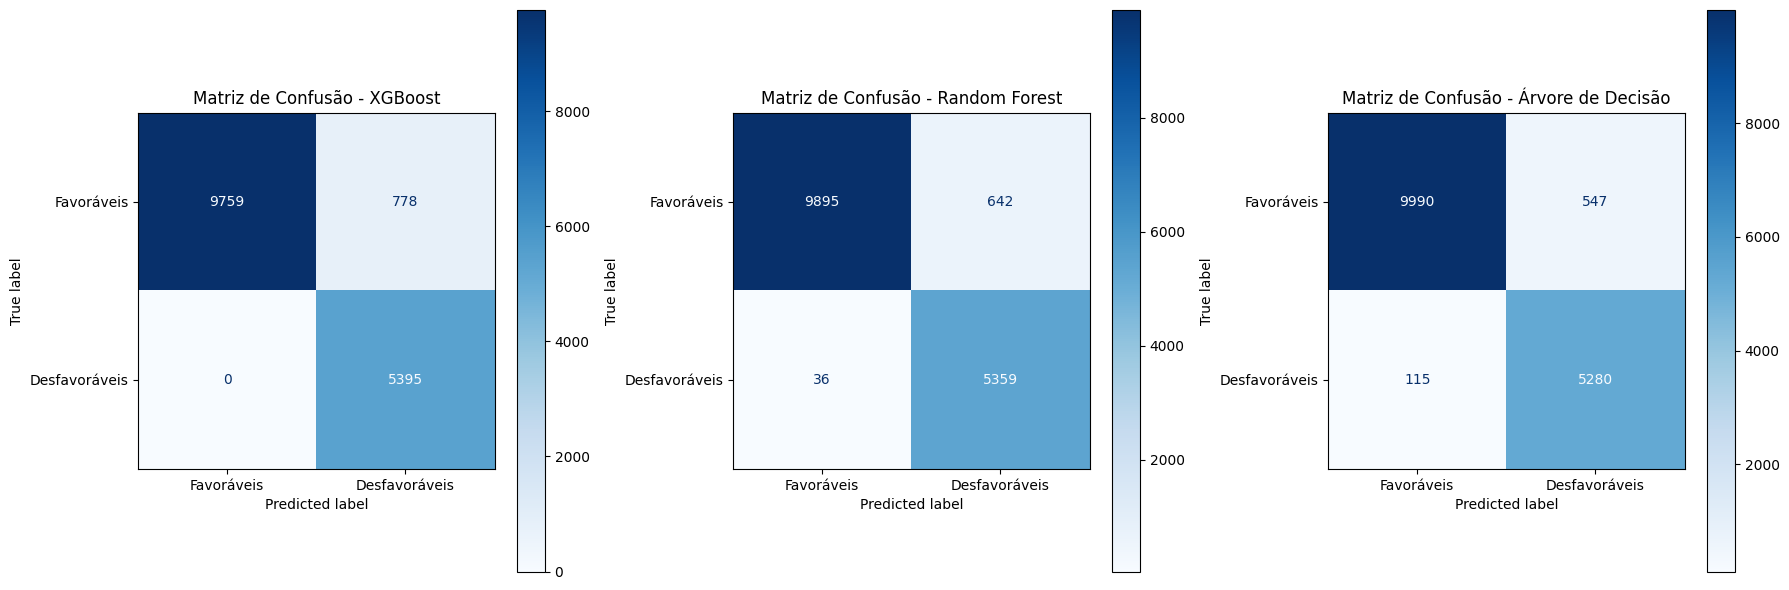

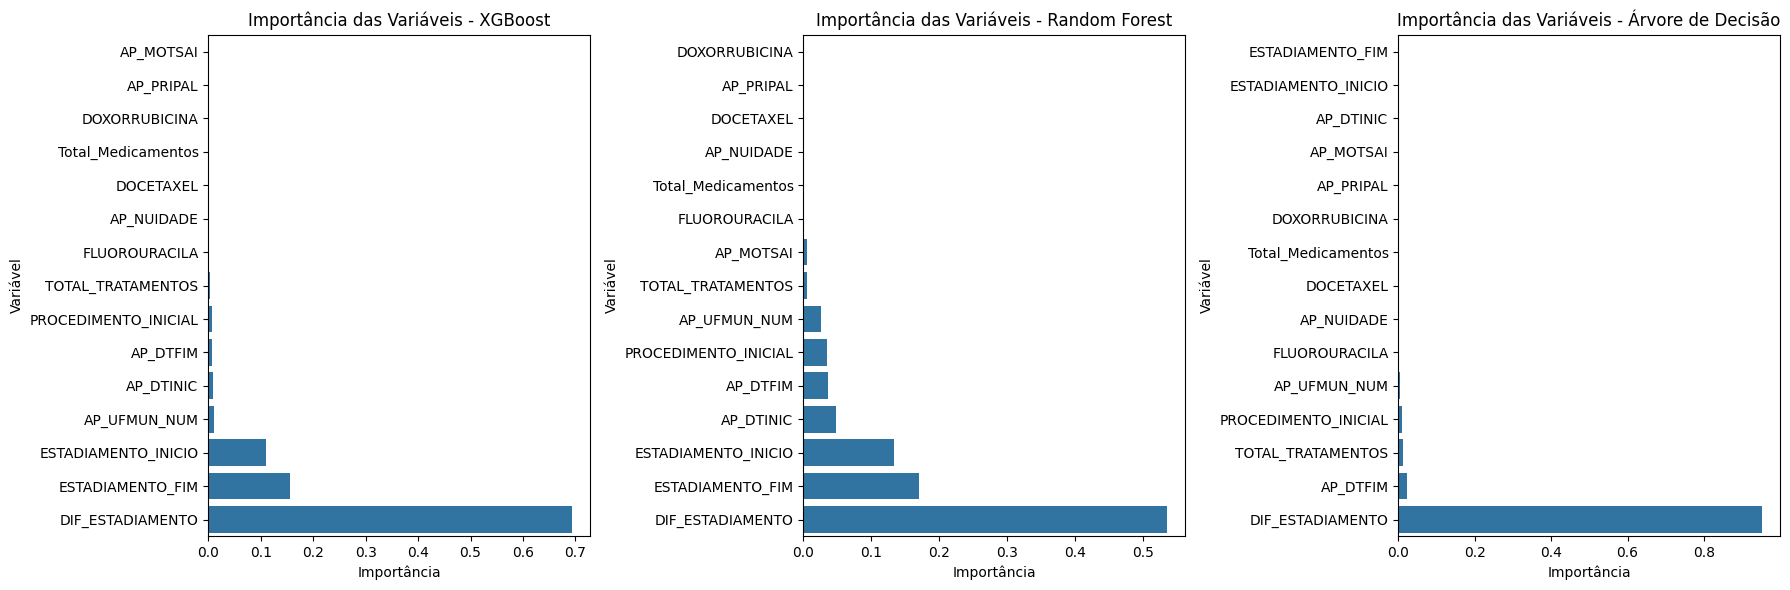

--------------------------------------------------

Verifique o arquivo 'emissions_comparison.csv' no seu diretório para os dados de consumo e emissões.


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from codecarbon import EmissionsTracker  # Importando o CodeCarbon


label_cols = ['AP_PRIPAL']
for col in label_cols:
    le = LabelEncoder()
    df_sem_alta[col] = le.fit_transform(df_sem_alta[col].astype(str))

# Seleção de variáveis
variaveis_selecionadas = [
    'DIF_ESTADIAMENTO', 'ESTADIAMENTO_FIM', 'ESTADIAMENTO_INICIO',
    'AP_DTINIC', 'AP_DTFIM', 'PROCEDIMENTO_INICIAL', 'AP_UFMUN_NUM',
    'AP_MOTSAI', 'TOTAL_TRATAMENTOS', 'AP_PRIPAL',
    'DOXORRUBICINA', 'Total_Medicamentos',
    'DOCETAXEL', 'AP_NUIDADE', 'FLUOROURACILA'
]

X = df_sem_alta[variaveis_selecionadas]
y = df_sem_alta['VALOR_DESFECHO']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Definindo o peso de classes
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()

# Espaço de busca para otimização
param_dist = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
}

# Espaço de busca para otimização do Random Forest
param_dist_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Espaço de busca para otimização da Árvore de Decisão
param_dist_dt = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Iniciando o monitoramento de emissões com o CodeCarbon
with EmissionsTracker(project_name="XGBoost Training", output_file="emissions_xgboost.csv") as tracker:
    # Instanciando o modelo base
    xgb_base = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        seed=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight_value
    )

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_dist,
        n_iter=20,
        scoring='recall',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    # Treinando modelo final com melhores parâmetros
    best_params = random_search.best_params_

    xgb_final = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight_value,
        **best_params
    )

    xgb_final.fit(X_train, y_train)

    # --- Treinamento Random Forest ---
    rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

    random_search_rf = RandomizedSearchCV(
        estimator=rf_base,
        param_distributions=param_dist_rf,
        n_iter=20,
        scoring='recall',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    random_search_rf.fit(X_train, y_train)

    # Treinando modelo final Random Forest
    best_params_rf = random_search_rf.best_params_

    rf_final = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **best_params_rf
    )

    rf_final.fit(X_train, y_train)

    # --- Treinamento Árvore de Decisão ---
    dt_base = DecisionTreeClassifier(random_state=42)

    random_search_dt = RandomizedSearchCV(
        estimator=dt_base,
        param_distributions=param_dist_dt,
        n_iter=20,
        scoring='recall',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    random_search_dt.fit(X_train, y_train)

    # Treinando modelo final Árvore de Decisão
    best_params_dt = random_search_dt.best_params_

    dt_final = DecisionTreeClassifier(
        random_state=42,
        **best_params_dt
    )

    dt_final.fit(X_train, y_train)

# Avaliação
y_pred_xgb = xgb_final.predict(X_test)
y_proba_xgb = xgb_final.predict_proba(X_test)[:, 1]

# Avaliação para Random Forest
y_pred_rf = rf_final.predict(X_test)
y_proba_rf = rf_final.predict_proba(X_test)[:, 1]

# Avaliação para Árvore de Decisão
y_pred_dt = dt_final.predict(X_test)
y_proba_dt = dt_final.predict_proba(X_test)[:, 1]

# Resultados do XGBoost
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")


# Resultados Random Forest
print("\nResultados do Random Forest:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")

# Resultados Árvore de Decisão
print("\nResultados da Árvore de Decisão:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_dt):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dt):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_dt):.4f}")

# Matrizes de Confusão
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Favoráveis", "Desfavoráveis"])

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Favoráveis", "Desfavoráveis"])

cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Favoráveis", "Desfavoráveis"])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

disp_xgb.plot(cmap='Blues', ax=axes[0], values_format='d')
axes[0].set_title("Matriz de Confusão - XGBoost")

disp_rf.plot(cmap='Blues', ax=axes[1], values_format='d')
axes[1].set_title("Matriz de Confusão - Random Forest")

disp_dt.plot(cmap='Blues', ax=axes[2], values_format='d')
axes[2].set_title("Matriz de Confusão - Árvore de Decisão")


plt.tight_layout()
plt.show()

# Importância das Variáveis
importancias_xgb = pd.Series(xgb_final.feature_importances_, index=X.columns).sort_values()
importancias_rf = pd.Series(rf_final.feature_importances_, index=X.columns).sort_values()
importancias_dt = pd.Series(dt_final.feature_importances_, index=X.columns).sort_values()

# Plotando importância das variáveis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x=importancias_xgb, y=importancias_xgb.index, ax=axes[0])
axes[0].set_title("Importância das Variáveis - XGBoost")
axes[0].set_xlabel("Importância")
axes[0].set_ylabel("Variável")

sns.barplot(x=importancias_rf, y=importancias_rf.index, ax=axes[1])
axes[1].set_title("Importância das Variáveis - Random Forest")
axes[1].set_xlabel("Importância")
axes[1].set_ylabel("Variável")

sns.barplot(x=importancias_dt, y=importancias_dt.index, ax=axes[2])
axes[2].set_title("Importância das Variáveis - Árvore de Decisão")
axes[2].set_xlabel("Importância")
axes[2].set_ylabel("Variável")

plt.tight_layout()
plt.show()

print("-" * 50)

# Para obter os resultados do CodeCarbon:
print("\nVerifique o arquivo 'emissions_comparison.csv' no seu diretório para os dados de consumo e emissões.")

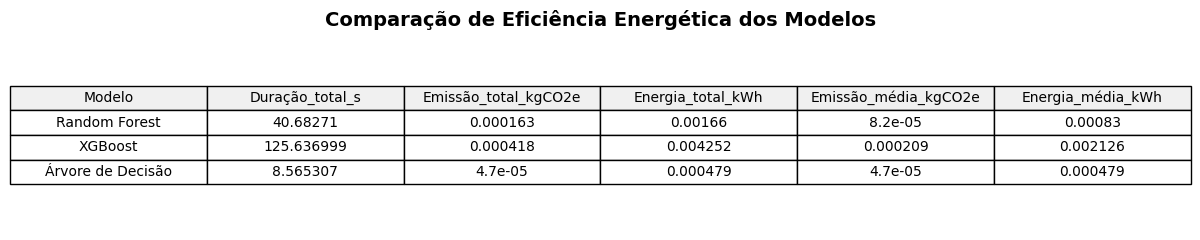

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Ler o CSV de emissões
df = pd.read_csv("emissions_xgboost.csv")

# 2. Atribuir manualmente os modelos a cada execução (ajuste conforme necessário)
modelos = ['Random Forest', 'Árvore de Decisão', 'Random Forest', 'XGBoost', 'XGBoost']
df['Modelo'] = modelos

# 3. Agrupar por modelo e calcular métricas
tabela_emissoes = df.groupby('Modelo')[['duration', 'emissions', 'energy_consumed']].agg(
    Duração_total_s=('duration', 'sum'),
    Emissão_total_kgCO2e=('emissions', 'sum'),
    Energia_total_kWh=('energy_consumed', 'sum'),
    Emissão_média_kgCO2e=('emissions', 'mean'),
    Energia_média_kWh=('energy_consumed', 'mean')
).reset_index()

# 4. Arredondar os valores para exibição
tabela_plot = tabela_emissoes.round(6)

# 5. Plotar com matplotlib
fig, ax = plt.subplots(figsize=(12, 2.5))
ax.axis('off')

# Criar tabela
table = ax.table(
    cellText=tabela_plot.values,
    colLabels=tabela_plot.columns,
    cellLoc='center',
    loc='center',
    colColours=['#f0f0f0'] * tabela_plot.shape[1]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Título opcional
plt.title("Comparação de Eficiência Energética dos Modelos", fontsize=14, weight='bold', pad=10)

plt.tight_layout()
plt.show()
